<a href="https://colab.research.google.com/github/hari-hashing/Vision_Tranformer_from_scratch_over_MNIST_dataset/blob/main/Vision_Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
import torch.utils.data as dataloader

In [3]:
import torchvision.transforms as transforms
# we need to convert it to tensor
transformations = transforms.Compose([transforms.ToTensor()])

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.83MB/s]


In [5]:
# defining the config for the model training
batch_size = 64
# MNIST dartaset is a black and white image so only on channel
num_channels = 1
num_classes = 10
img_size = 28
# this is the size of image in the MNIST dataset
patch_size = 7
patch_num = (img_size//patch_size)*(img_size//patch_size)
# img_size//patch_size this // corresponds to the integer division
attention_heads = 4
embed_dim = 20
transformer_blocks = 4
mlp_nodes = 64
learning_rate = 0.0001
epochs = 100
# we could have specified any number

In [6]:
# converting the dataset into batches for NN training
# using a dataloader
batch_size = 64
train_data = dataloader.DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
val_dataset = dataloader.DataLoader(val_dataset,batch_size = batch_size,shuffle = True)

In [7]:
from ast import Num
# class for PatchEmbedding
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    # it will inherit properties from the previous
    #  look into it how na dwaht it does
    self.patch_embed = nn.Conv2d(num_channels,embed_dim,kernel_size = patch_size,stride = patch_size)

  def forward(self,x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x


In [8]:
# images,labels this is what a dataloader returns
images,labels = next(iter(train_data))
print(images.shape)
# batch size = 64 num-channel = 1 img size = 28,28
patch_embed = nn.Conv2d(num_channels,embed_dim,kernel_size = patch_size,stride = patch_size)
embedded_img = patch_embed(images)
print(embedded_img.shape)
print(embedded_img.flatten(2).shape)
# we want the embed dim should be the last thing and the num patches the second
# so we may have to transpose so that the the forst and the second dim gets transposed
embedded_img = embedded_img.flatten(2).transpose(1,2)
print(embedded_img.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 20, 4, 4])
torch.Size([64, 20, 16])
torch.Size([64, 16, 20])


In [9]:
# [64, 20, 4, 4] this means that 20 is the embed dim and 4,4 is the num of patches in the x and y directions


In [10]:
# class for Transformer encoder - Part2 of the ViT architecture
# Layer Normallization
# Multihead Attention
# Layer Norm
# Residuals
# Mlp - activation function

class Transformerencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.multi_head_attention = nn.MultiheadAttention(embed_dim,num_heads = attention_heads)
    # at the end we are concatenating the vector so that we get back the whole 20 dim or the embed dim vector
    self.layer_norm2 = nn.LayerNorm(embed_dim)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim,mlp_nodes),
        nn.GELU(),
        nn.Linear(mlp_nodes,embed_dim)
        #  we may add based on requirement
        # nn.GELU()
        # nn.Linear(embed_dim,mlp_nodes),
        # nn.GELU(),
    )

  # this shows the code for one transformer encoder block
  def forward(self,x):
    residual1 = x
    x = self.layer_norm1(x)
    # as we have to calculate the key querry and value seperately from x input thus we pass x,x,x
    # like key=x@Wk , querry=x@Wq , value=x@Wv
    x = self.multi_head_attention(x,x,x)[0]
    residual2 = x
    x = x + residual1
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = x + residual2
    return x

In [11]:
#  Class for MLP head for classification - Part 3 of the ViT architecture

class MLPhead(nn.Module):
  def __init__(self):
    super().__init__()
    # we can add a layer norm over it as it may prevent overfitting
    # self.layer_norm1 = nn.LayerNorm(embed_dim) # Removed redundant layer norm
    self.mlphead= nn.Sequential(
        nn.Linear(embed_dim,num_classes), # Corrected output dimension to num_classes
    )

  def forward(self,x):
    # we are only going to use the CLS token for the classification which will be passed in the MLP head
    # other tokens or the patch+pos embed token will not be used
    # x = x[:,0] # Removed this line as CLS token is already selected in VisionTransformer's forward
    # at the 0th position we have the CLS token
    # x = self.layer_norm1(x) # Removed redundant layer norm
    x = self.mlphead(x)
    return x

In [12]:
class VisionTransformer(nn.Module):

  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    # we did not add the cls token initially so we do it now
    # we need the cls token for each image in the batch for each image we are looking at one vector of embed_dim
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    # we did not add the pos embedding initially so we do it now
    # we need as many pos embedding as there are patches
    # we also add the pos embedding ot the cls token not only to the patches thus we do patch_num+1
    self.pos_embedding = nn.Parameter(torch.randn(1,patch_num+1,embed_dim))
    # for adding the transformer blocks in series we have to use nn.Sequential
    self.transformer_blocks = nn.Sequential(*[Transformerencoder() for _ in range(transformer_blocks)])
    self.mlp_head = MLPhead()

  def forward(self,x):
    x = self.patch_embedding(x)
    # now we have to add batch size number of CLS tokens
    # as we explicitely define or hard code the batch szie but the number of batches
    # depends on wether the number of images in the dataset is divisible by the batch size we specified or not
    B = x.size(0)
    #  thus we need to expand the cls token
    cls_tokens = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_tokens,x),1)
    x = x + self.pos_embedding
    x = self.transformer_blocks(x)
    x = x[:,0]
    # we use only cls token for classification purpose only
    x = self.mlp_head(x)
    return x

In [13]:
# device
# optimizer
# crossentropy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [14]:
# defining the training loop
train_acc = []
train_loss = []
for i in range(epochs):
  model.train()
  total_images = 0
  correct_images = 0

  for images,labels in train_data:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model(images)

    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    predictions = output.argmax(dim = 1) # Corrected 'outputs' to 'output'
    correct_predictions = (predictions == labels).sum().item()
    correct_images += correct_predictions
    total_images += labels.size(0)
    train_acc.append(correct_images/total_images)


In [15]:
for i in range(len(train_acc)):
  print(train_acc[i])

Streaming output truncated to the last 5000 lines.
0.11153616852146264
0.11150793650793651
0.11152931854199682
0.11152590981012658
0.11152251184834124
0.11154376971608833
0.11158956692913385
0.11156151729559749
0.1115335557299843
0.11150568181818182
0.11152679968701096
0.111572265625
0.11173946957878315
0.11171144859813084
0.11170781493001555
0.11165566770186336
0.11165213178294574
0.1117453560371517
0.11171754250386398
0.11173804012345678
0.11175847457627118
0.1117548076923077
0.11167914746543779
0.11179543711656442
0.11176780245022971
0.11174025229357798
0.11171278625954198
0.11173304115853659
0.11177701674277017
0.11182085866261399
0.11186456752655538
0.11190814393939394
0.11190431164901664
0.11199490181268883
0.1120145173453997
0.1121046686746988
0.11203007518796992
0.11207301051051051
0.11206896551724138
0.11201815119760479
0.11196748878923767
0.1118936567164179
0.1118666169895678
0.11195591517857142
0.11199851411589896
0.11192507418397626
0.1119212962962963
0.1119637573964497
0.1

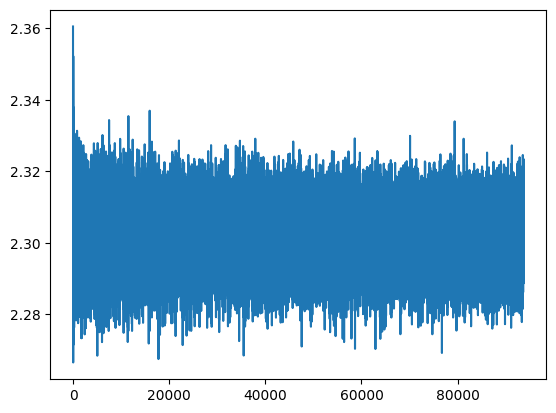

In [16]:
plt.plot(train_loss)
plt.show()

In [18]:
# Saving the model path weights and the architecture

# saving only the weights
torch.save(model.state_dict(),'ViT_model_MNIST_weights.pth')

# saving the model weights and the architecture
torch.save(model,'ViT_model_MNIST_architecture.pth')


In [ ]:
# loading the model for inference and setting to eval
model = torch.load('ViT_model_MNIST_architecture.pth')
model.eval()